In [1]:
import sys
sys.path.append("../")

In [2]:
import os 
import glob
import cv2
import matplotlib.pyplot as plt
%matplotlib inline 
import numpy as np
import importlib
import random
import time
from datetime import datetime
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers.schedules import PiecewiseConstantDecay
from tensorflow.keras.optimizers import SGD, Adam

import tensorflow as tf
from tensorflow.python.client import device_lib
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from tensorflow.compat.v1 import Session
from tensorflow.compat.v1 import get_default_graph

from EDSR import data_generator as data_generator
from EDSR import config as config
from EDSR import utils as utils
from EDSR import losses as losses
from EDSR import models as models
from EDSR import lr_finder as lr_finder
from EDSR import custom_callbacks as custom_callbacks 

seed = 2020
os.environ['PYTHONHASHSEED'] = '0'                      
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

session_conf = ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = Session(graph=get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)


In [7]:
importlib.reload(utils)
importlib.reload(data_generator)
importlib.reload(models)
importlib.reload(losses)


<module 'EDSR.losses' from '../EDSR/losses.py'>

In [4]:
crop_size = 96
img_path = config.DATA_PATH
batch_size = 64
scale = 2
epochs = 30

img_path_list = sorted(glob.glob(os.path.join(img_path, '*.jpg')))
test_size = 0.2
img_path_idx = np.arange(len(img_path_list))
train_img_path, val_img_path, train_img_idx, val_img_idx = train_test_split(img_path_list, img_path_idx, \
                                                                            test_size=test_size, random_state=2020)
print(len(train_img_idx), len(val_img_idx))  
train_gen = data_generator.DataGenerator(img_path_list=train_img_path, crop_size=crop_size, 
                                         batch_size=batch_size, scale=scale, shuffle=True, crop=True, flip=True)

val_gen = data_generator.DataGenerator(img_path_list=val_img_path, crop_size=crop_size,
                                         batch_size=batch_size, scale=scale, shuffle=True, crop=True, flip=False)

5912 1478


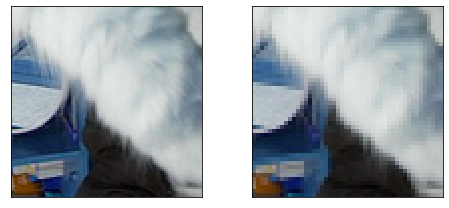

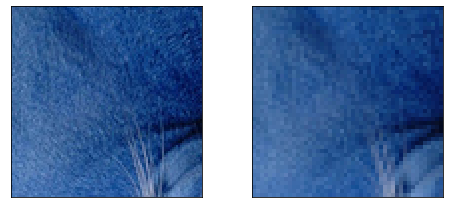

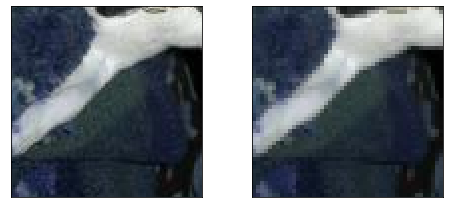

In [5]:
batch_lr_img, batch_hr_img = next(iter(train_gen))

show_num = 3
for i in range(len(batch_hr_img[:show_num])):
    utils.show_batch_imgs(idx=i, demo_ori_img=batch_hr_img[:show_num], demo_lr_img=batch_lr_img[:show_num])


In [7]:

edsr_model = models.edsr(scale=scale, num_filters=64, num_res_blocks=8, res_block_scaling=None)
# print(edsr_model.summary())

adam = Adam(lr=0.001)
# compile model
edsr_model.compile(optimizer=adam, loss='mae',  metrics=[losses.SSIM])


Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
Train for 93 steps
Epoch 1/3
93/93 [==============================] - 20s 216ms/step - loss: 0.4242 - SSIM: 0.0457
Epoch 2/3
80/93 [========================>.....] - ETA: 2s - loss: 0.1056 - SSIM: 0.3234

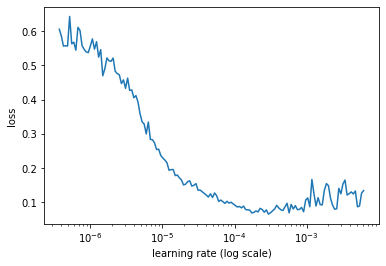

In [8]:
lr_finder = lr_finder.LRFinder(edsr_model)
lr_finder.find_generator(generator=train_gen, start_lr=1e-07, end_lr=10, epochs=3)
lr_finder.plot_loss(n_skip_beginning=20, n_skip_end=5)


In [1]:
# for i in range(3000):
#     batch = i
#     if i % 100 ==0:
#         print('***', i)
#         print(i, decay_func(batch, 1e-3, 0.75, 100))
# #     print(i+1, decay_func(batch, 1e-3, 0.75, 100))

In [2]:
# importlib.reload(custom_callbacks)

# log_filename = datetime.now().strftime("%Y-%m-%d_%H:%M:%S") + 'EDSR_MAE_lr_decay.log'
# log_path = os.path.join('/work/logs', log_filename) 
# csv_logger = CSVLogger(log_path, separator=',', append=False)

# epoch_size = len(train_gen)

# def decay_func(step, start_lr, exp_decay, decay_steps):
# #     return start_lr * math.exp(-(step /decay_steps) ** exp_decay)
#     return (exp_decay ** (step /decay_steps) )* start_lr

# def lr_schedule(batch, epoch_size=epoch_size):
#     if batch < epoch_size*10:
#         cur_lr = decay_func(batch, 1e-3, 0.75, 100)
#     else:
#         cur_lr = decay_func(batch, 1e-5, 0.75, 100)
#     return cur_lr

# edsr_model = models.edsr(scale=scale, num_filters=64, num_res_blocks=8, res_block_scaling=None) 

# lr_callback = custom_callbacks.CustomLearningRateScheduler(schedule=lr_schedule, epoch_size=epoch_size, verbose=0)
# opt = Adam(learning_rate=lr_schedule(0))

# edsr_model.compile(optimizer=opt, loss='mae',  metrics=[losses.SSIM])
# checkpoint = ModelCheckpoint("EDSR_MAE_lr_decay.h5", monitor='val_SSIM', save_best_only=True,
#                              save_weights_only=False, mode='max')

# callbacks_list = [lr_callback, csv_logger, checkpoint]
# # callbacks_list = [lr_callback]

# # train for 93 *30 = 2940 steps
# history = edsr_model.fit(train_gen, epochs=epochs,  
#                     validation_data = val_gen,
#                     callbacks=callbacks_list)


In [21]:

edsr_model = models.edsr(scale=scale, num_filters=64, num_res_blocks=8, res_block_scaling=None) 

opt = Adam(learning_rate=PiecewiseConstantDecay(boundaries=[930, 2000], values=[1e-3, 5e-4, 1e-5]))
log_filename = datetime.now().strftime("%Y-%m-%d_%H:%M:%S") + 'EDSR_MAE_lr_stepwise_decay.log'
log_path = os.path.join('/work/logs', log_filename) 
csv_logger = CSVLogger(log_path, separator=',', append=False)

edsr_model.compile(optimizer=opt, loss='mae',  metrics=[losses.SSIM])
checkpoint = ModelCheckpoint("EDSR_MAE_lr_stepwise_decay.h5", monitor='val_SSIM', save_best_only=True,
                             save_weights_only=False, mode='max')

callbacks_list = [checkpoint, csv_logger]

# train for 93 *30 = 2940 steps
history = edsr_model.fit(train_gen, epochs=epochs,  
                         validation_data = val_gen,
                         callbacks=callbacks_list)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 93 steps, validate for 24 steps
Epoch 1/30
93/93 [==============================] - 25s 268ms/step - loss: 0.1740 - SSIM: 0.4610 - val_loss: 0.0368 - val_SSIM: 0.7205
Epoch 2/30
93/93 [==============================] - 24s 254ms/step - loss: 0.0346 - SSIM: 0.7533 - val_loss: 0.0307 - val_SSIM: 0.7851
Epoch 3/30
93/93 [==============================] - 23s 253ms/step - loss: 0.0295 - SSIM: 0.8028 - val_loss: 0.0263 - val_SSIM: 0.8226
Epoch 4/30
93/93 [==============================] - 23s 252ms/step - loss: 0.0282 - SSIM: 0.8165 - val_loss: 0.0315 - val_SSIM: 0.7971
Epoch 5/30
93/93 [==============================] - 23s 252ms/step - loss: 0.0263 - SSIM: 0.8320 - val_loss: 0.0288 - val_SSIM: 0.8158
Epoch 6/30
93/93 [==============================] - 23s 252ms/step - loss: 0.0279 - SSIM: 0.8317 - val_loss: 0.0257 - val_SSIM: 0.8399
Epoch 7/30
93/93 [==============================] - 23s 252ms/step - loss: 0.0266 - SSIM: 0.8431 -

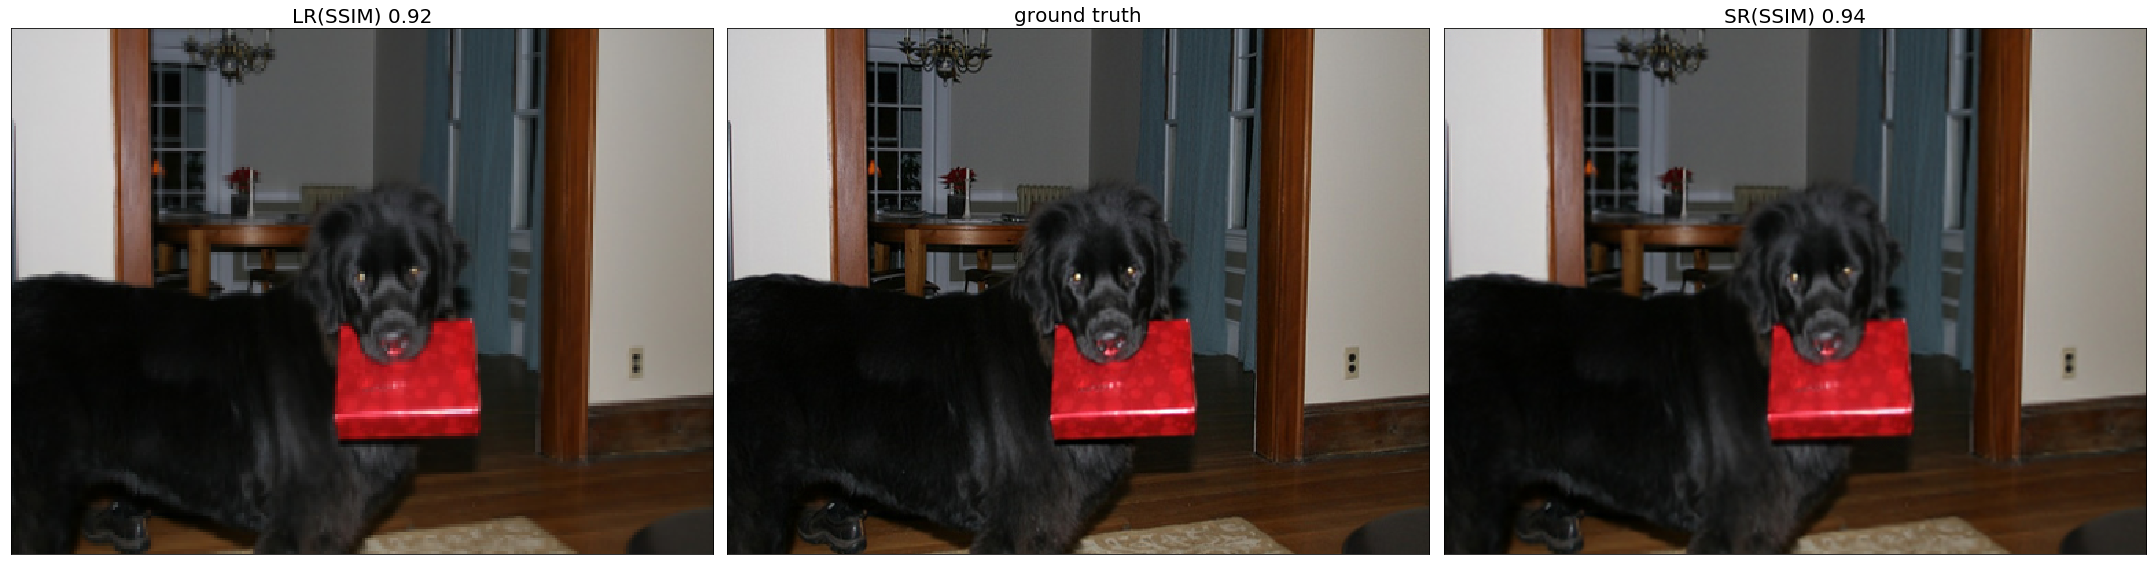

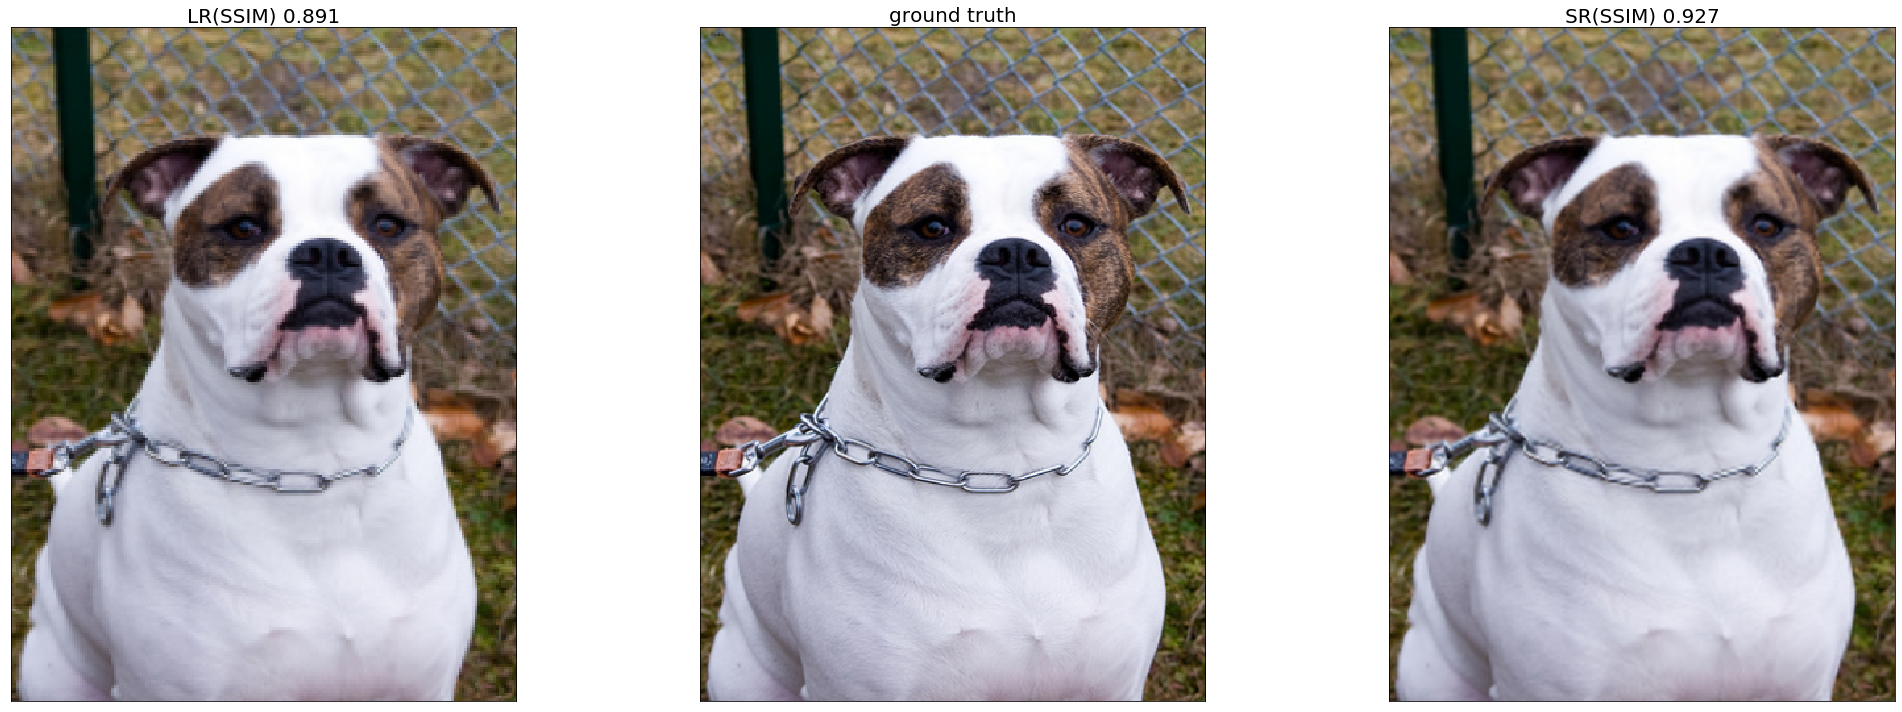

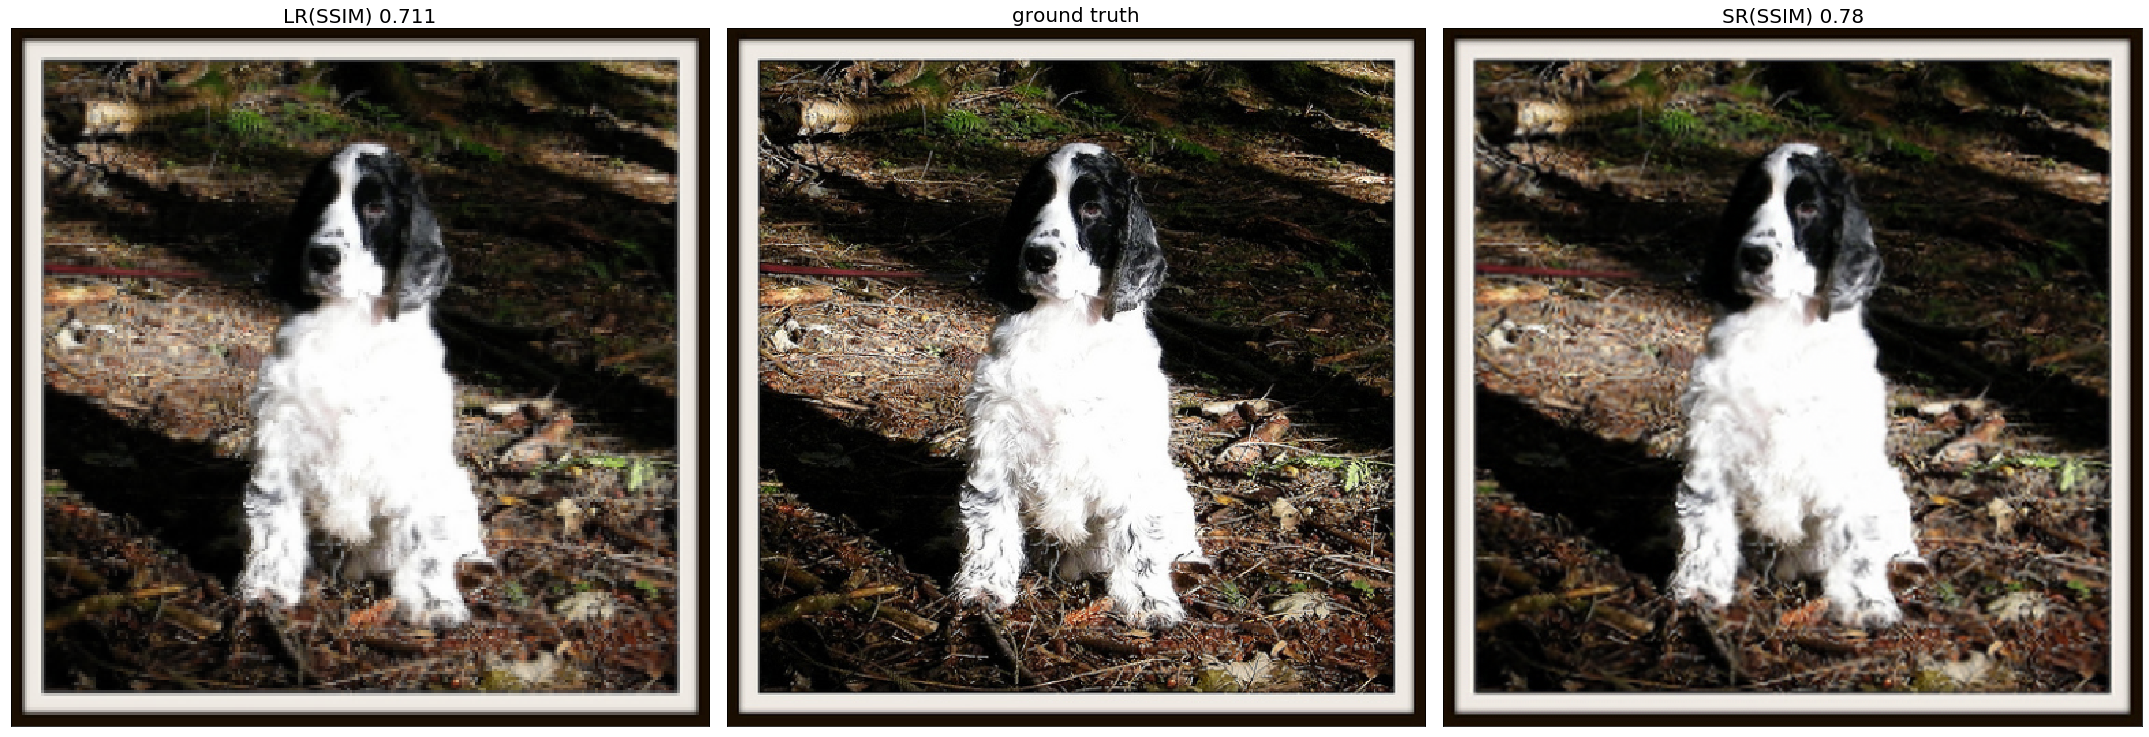

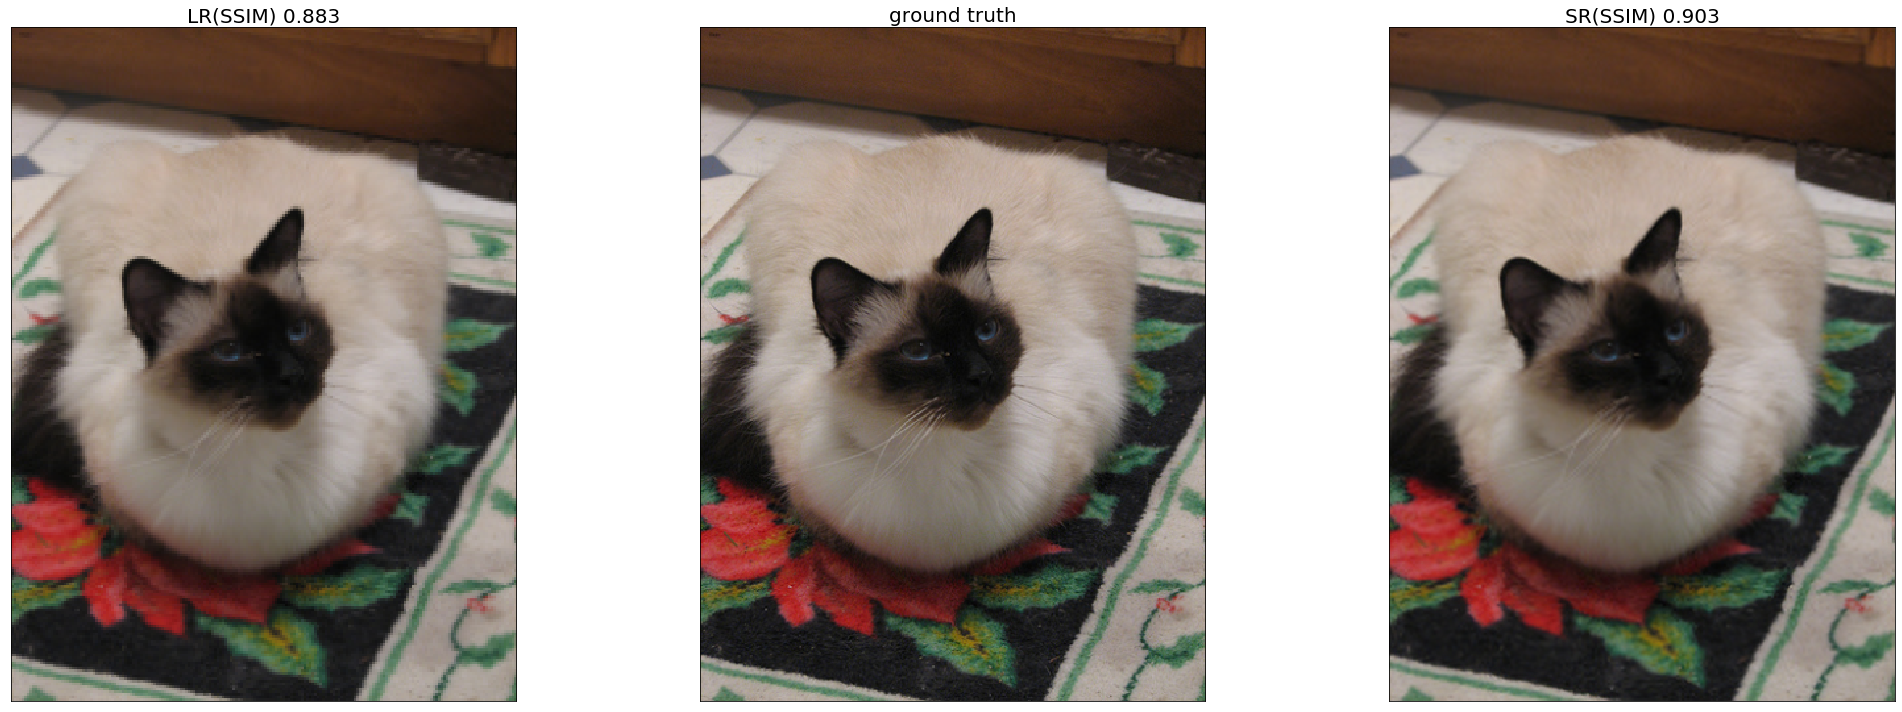

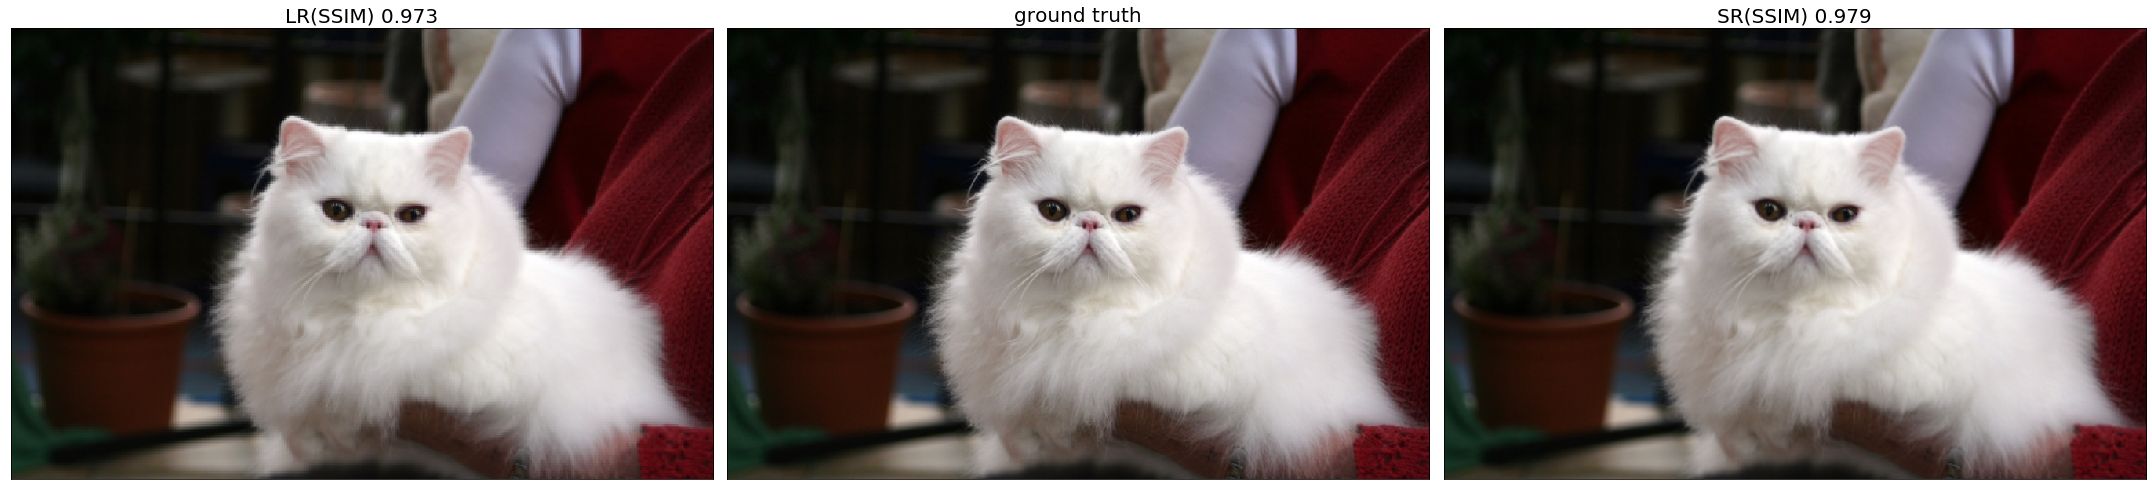

In [8]:
edsr_model = models.edsr(scale=scale, num_filters=64, num_res_blocks=8, res_block_scaling=None)
# edsr_model.load_weights("EDSR_MAE_lr_decay.h5")
edsr_model.load_weights("EDSR_MAE_lr_stepwise_decay.h5")
utils.predict_and_show(val_img_path[:5], edsr_model, 2, keep_dim = False, multi_255 = True)
